# Are MOFs Generated by Later Models Better?
We periodically retrain the DiffLinker, and hope that the ones generated by later interations of the model are better.

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import json
import gzip
import numpy as np
import seaborn as sns

In [5]:
run_dir = Path('../../datasets/')

In [6]:
Path('figures').mkdir(exist_ok=True)

## Load the Data from Disk
And make it compact


In [31]:
records = []
with gzip.open(run_dir / 'mofs.json.gz', 'rt') as fp:
    for line in tqdm(fp):
        record = json.loads(line)

        # Remove structure data, label linkers by anchor
        for k in ['md_trajectory', 'nodes', 'structure', '_id']:
            del record[k]
        for ligand in record.pop('ligands'):
            record[f'ligand.{ligand["anchor_type"]}'] = ligand
            for k in ['xyz', 'dummy_element', 'anchor_type']:
                del ligand[k]

        record['time'] = record.pop('times')['created']['$date']
        records.append(pd.json_normalize(record))
records = pd.concat(records, ignore_index=True)

5162it [00:15, 342.25it/s]


Store the model versions

In [54]:
records[~records['gas_storage.CO2'].isna()]

,name,topology,catenation,time,gas_storage.CO2,structure_stability.uff,ligand.COO.name,ligand.COO.smiles,ligand.COO.prompt_atoms,ligand.COO.metadata.model_version,ligand.cyano.name,ligand.cyano.smiles,ligand.cyano.prompt_atoms,ligand.cyano.metadata.model_version,model_version,walltime
1,mof-0bb848bf,None,None,2024-04-10 22:40:20.826,"[10000.0, 0.0863105234]",0.143220,ligand-c39cb572,O=C([O-])c1ccc(C2=N[C@@H](/C=N/C=N\C(=O)c3ccc(...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0,ligand-336f8e62,N#Cc1ccc(/C=C/O/N=N/N=C/N=C/c2ccc(C#N)cc2)cc1,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, ...",0,0,3.026
0,mof-914dc5d3,None,None,2024-04-10 22:40:30.030,"[10000.0, 0.0812803773]",0.173883,ligand-c39cb572,O=C([O-])c1ccc(C2=N[C@@H](/C=N/C=N\C(=O)c3ccc(...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0,ligand-9fda0c60,N#Cc1ccc(/C=C/N=[O+]/C([O-])=N/N=C/c2ccc(C#N)c...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, ...",0,0,12.230
2,mof-9b3024dd,None,None,2024-04-10 22:40:38.883,"[10000.0, 0.1478145114]",0.988985,ligand-5b6ef7e9,O=C([O-])c1ccc(C(=O)/N=[O+]\[C@@H]([O-])/[O+]=...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0,ligand-a3856ecf,N#Cc1ccc(/C=C/N=[O+]/C([O-])=N/N=C/c2ccc(C#N)c...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, ...",0,0,21.083
1300,mof-d98f8cda,None,None,2024-04-10 23:23:13.668,"[10000.0, 0.0884380709]",0.047997,ligand-6b9acb34,O=C([O-])c1ccc(/C=C/N/C=C2\C=C(c3ccc(C(=O)O)cc...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",28,ligand-ea8365d0,N#Cc1ccc(/C=C/OOC(=O)O/N=C/c2ccc(C#N)cc2)cc1,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, ...",29,29,2575.868


In [32]:
records['model_version'] = records[['ligand.cyano.metadata.model_version', 'ligand.COO.metadata.model_version']].max(axis=1)

In [33]:
records['time'] = records['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
records['walltime'] = (records['time'] - records['time'].min()).apply(lambda x: x.total_seconds())

In [34]:
records.sort_values('walltime', inplace=True)

## Plot Stability over Time
Do they get better or worse over time?

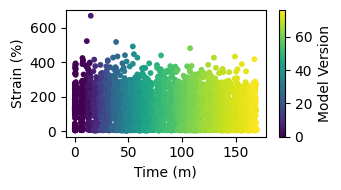

In [35]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

sc = ax.scatter(records['walltime'] / 60, records['structure_stability.uff'] * 100, s=10,
           c=records['ligand.cyano.metadata.model_version'])

fig.colorbar(sc, label='Model Version')

ax.set_xlabel('Time (m)')
ax.set_ylabel('Strain (%)')

fig.tight_layout()fig.savefig('figures/stability-over-time.png', dpi=320)

## Violin plot

In [55]:
def plot_violin_by_time(data, time_col, y_col, y_name, model_version_col, bin_width, figsize=(3.5, 2), dpi=320, save_path='figures/stability-over-time-violin.png'):
    df = data.copy()
    df['Time Bin'] = np.floor(df[time_col] / 60 / bin_width) * bin_width
    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(x='Time Bin', y=y_col, data=df, ax=ax, density_norm='width', palette="muted")

    ax.set_xlabel('Time (min)')
    ax.set_ylabel(f'{y_name} (%)')
    ax.set_title(f'{y_name} by Time Interval')

    fig.tight_layout()
    fig.savefig(save_path, dpi=dpi)
    plt.show()

/var/folders/pb/vktf3d2x011442j3m334qsn80000gn/T/ipykernel_61417/296077658.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Time Bin', y=y_col, data=df, ax=ax, density_norm='width', palette="muted")


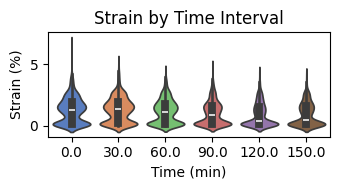

In [57]:
plot_violin_by_time(
    data=records,
    time_col='walltime',
    #gas_storage.CO2
    #structure_stability.uff
    y_col='structure_stability.uff',
    y_name="Strain",
    model_version_col='ligand.cyano.metadata.model_version',
    bin_width=30  # Bin width of 10 minutes
)

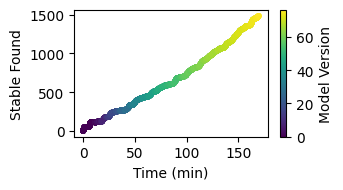

In [58]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

count = (records['structure_stability.uff'] < 0.2).cumsum()
sc = ax.scatter(
    records['walltime'] / 60, count,
    s=10, c=records['ligand.cyano.metadata.model_version']
)
ax.step(records['walltime'] / 60, count, zorder=-1, c='k', lw=1)

fig.colorbar(sc, label='Model Version')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Stable Found')

fig.tight_layout()
fig.savefig('figures/stability-over-time-step.png', dpi=320)

We don't yet see a benefit. The rate of increases don't seem to be significant.